In [1]:
%%capture
!pip install diskcache

In [2]:
import pandas
import json
import matplotlib.pyplot as plt
import time
import contextlib
import gc
import xarray_open_test as xot
import sys; sys.path.append('..')
from helpers import eodc_hub_role
credentials = eodc_hub_role.fetch_and_set_credentials()

## Load datasets to test

In [3]:
datasets = json.loads(open('../01-generate-datasets/external-datasets.json', 'r').read())
dataset_args = [{'src_path': src['dataset_url'], 'reference': src.get('extra_args', {}).get('reference', None)} for src in datasets.values()]
dataset_args    

[{'src_path': 's3://power-analysis-ready-datastore/power_901_monthly_meteorology_utc.zarr',
  'reference': None},
 {'src_path': 's3://cmip6-pds/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r2i1p1f1/Amon/tas/gn/v20180827/',
  'reference': None},
 {'src_path': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/aws-noaa-oisst-feedstock/aws-noaa-oisst-avhrr-only.zarr/reference.json',
  'reference': True}]

## Clear memory in-between tests

In [4]:
@contextlib.contextmanager
def clear_memory():
    try:
        yield
    finally:
        gc.collect()

## Run tests

In [5]:
# List of functions and datasets
functions = [xot.fsspec_xarray_open_dataset, xot.diskcache_xarray_open_dataset, xot.xarray_open_dataset]
results_df = {}
ntests = 6
# Running each function against each dataset 5 times
for func in functions:
    results_df[func.__name__] = {}
    for dataset in dataset_args:
        
        times = []
        for _ in range(ntests):
            start_time = time.time()
            with clear_memory():
                ds = func(**dataset)
                ds.close()
            end_time = time.time()
            times.append(end_time - start_time)
        
        results_df[func.__name__][dataset['src_path']] = times



/home/jovyan/tile-benchmarking/02-run-tests/xarray_open_test.py:38: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  return xarray.open_dataset(src_path, **xr_open_args)
/home/jovyan/tile-benchmarking/02-run-tests/xarray_open_test.py:38: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  return xarray.open_dataset(src_path, **xr_open_args)
/home/jovyan/tile-benchmarking/02-run-tests/xarray_open_test.py:38: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  return xarray.open_dataset(src_path, **xr_open_args)


# Cleanup the cache between tests

You need to shutdown the kernel first though. Diskcache appears to keep files open ([Cache objects open and maintain one or more file handles](https://grantjenks.com/docs/diskcache/tutorial.html#cache)).

In [6]:
# Cleanup the cache between tests
#!rm -rf fsspec_cache 
#!rm -rf diskcache

## Load results into a dataframe and plot them.

Note: There is startup time with the cache operations so the time for the first test is reported separately from the other tests.

Startup time for fsspec_xarray_open_dataset and s3://power-analysis-ready-datastore/power_901_monthly_meteorology_utc.zarr: 3.85

Startup time for diskcache_xarray_open_dataset and s3://power-analysis-ready-datastore/power_901_monthly_meteorology_utc.zarr: 0.46

Startup time for xarray_open_dataset and s3://power-analysis-ready-datastore/power_901_monthly_meteorology_utc.zarr: 0.33



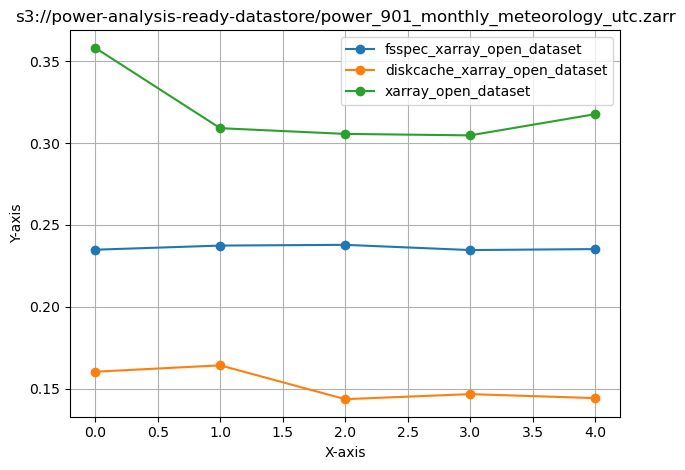

Startup time for fsspec_xarray_open_dataset and s3://cmip6-pds/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r2i1p1f1/Amon/tas/gn/v20180827/: 0.47

Startup time for diskcache_xarray_open_dataset and s3://cmip6-pds/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r2i1p1f1/Amon/tas/gn/v20180827/: 0.23

Startup time for xarray_open_dataset and s3://cmip6-pds/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r2i1p1f1/Amon/tas/gn/v20180827/: 0.22



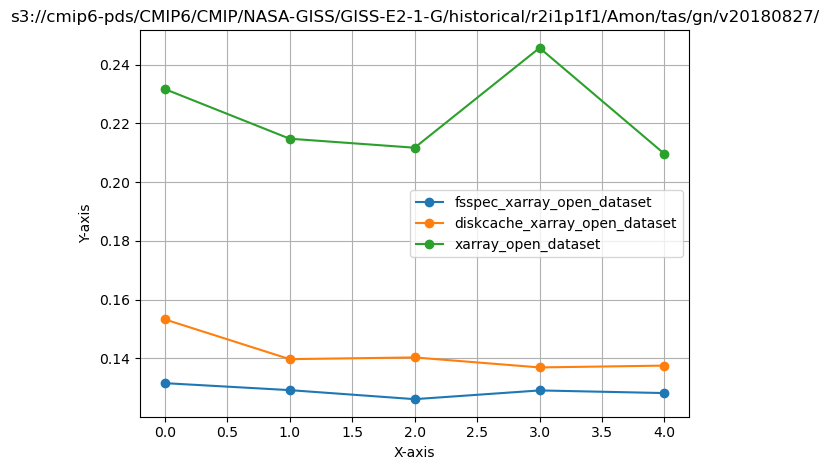

Startup time for fsspec_xarray_open_dataset and https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/aws-noaa-oisst-feedstock/aws-noaa-oisst-avhrr-only.zarr/reference.json: 2.73

Startup time for diskcache_xarray_open_dataset and https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/aws-noaa-oisst-feedstock/aws-noaa-oisst-avhrr-only.zarr/reference.json: 1.96

Startup time for xarray_open_dataset and https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/aws-noaa-oisst-feedstock/aws-noaa-oisst-avhrr-only.zarr/reference.json: 0.41



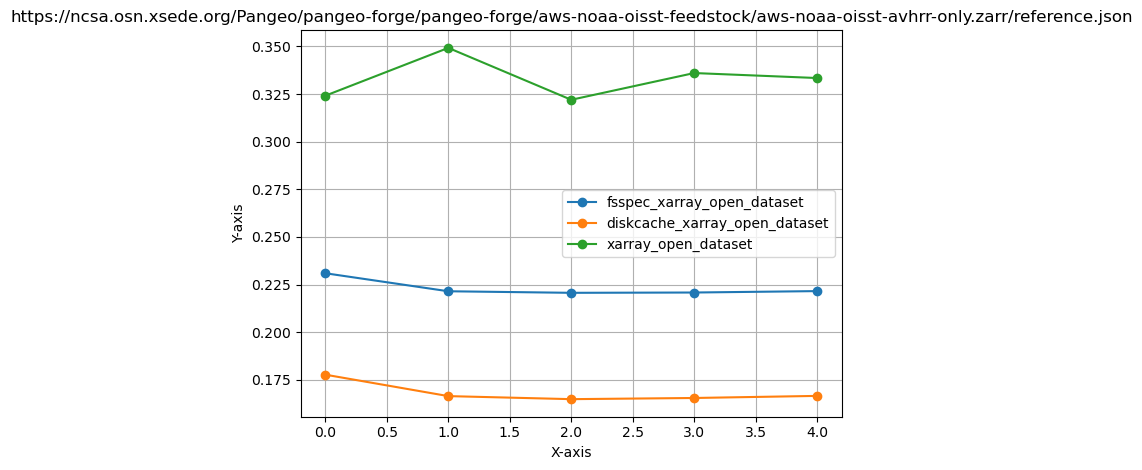

In [7]:
df = pandas.DataFrame(results_df)
x = range(ntests-1)
for dataset in dataset_args:
    for func in functions:
        times = df[func.__name__][dataset['src_path']]
        print(f"Startup time for {func.__name__} and {dataset['src_path']}: {round(times[0], 2)}\n")
        y = times[1:]

        # Plot the data
        plt.plot(x, y, label=func.__name__, marker='o')

    # Add labels, title, and legend
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(dataset['src_path'])
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()
